In [41]:
import pickle as pkl
import numpy as np 
from matplotlib import pyplot as plt
from filterpy.kalman import KalmanFilter

Links: 
 - https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
 - https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html#r64ca38088676-2
 - https://pubmed.ncbi.nlm.nih.gov/20172805/

### combined runs, raw data 

In [3]:
#C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\Combined_runs
with open("sub_000_comb.p", 'rb') as pickle_file:
    dat = pkl.load(pickle_file)

In [8]:
dat["ECOG_RIGHT_0"]["data"].shape

(761002,)

### feature extracted data 

In [9]:
#C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\derivatives\Int_old_grid
with open("sub_000_sess_right_run_0.p", 'rb') as pickle_file:
    dat = pkl.load(pickle_file)

In [12]:
dat["rf_data_median"].shape

(1290, 6, 8)

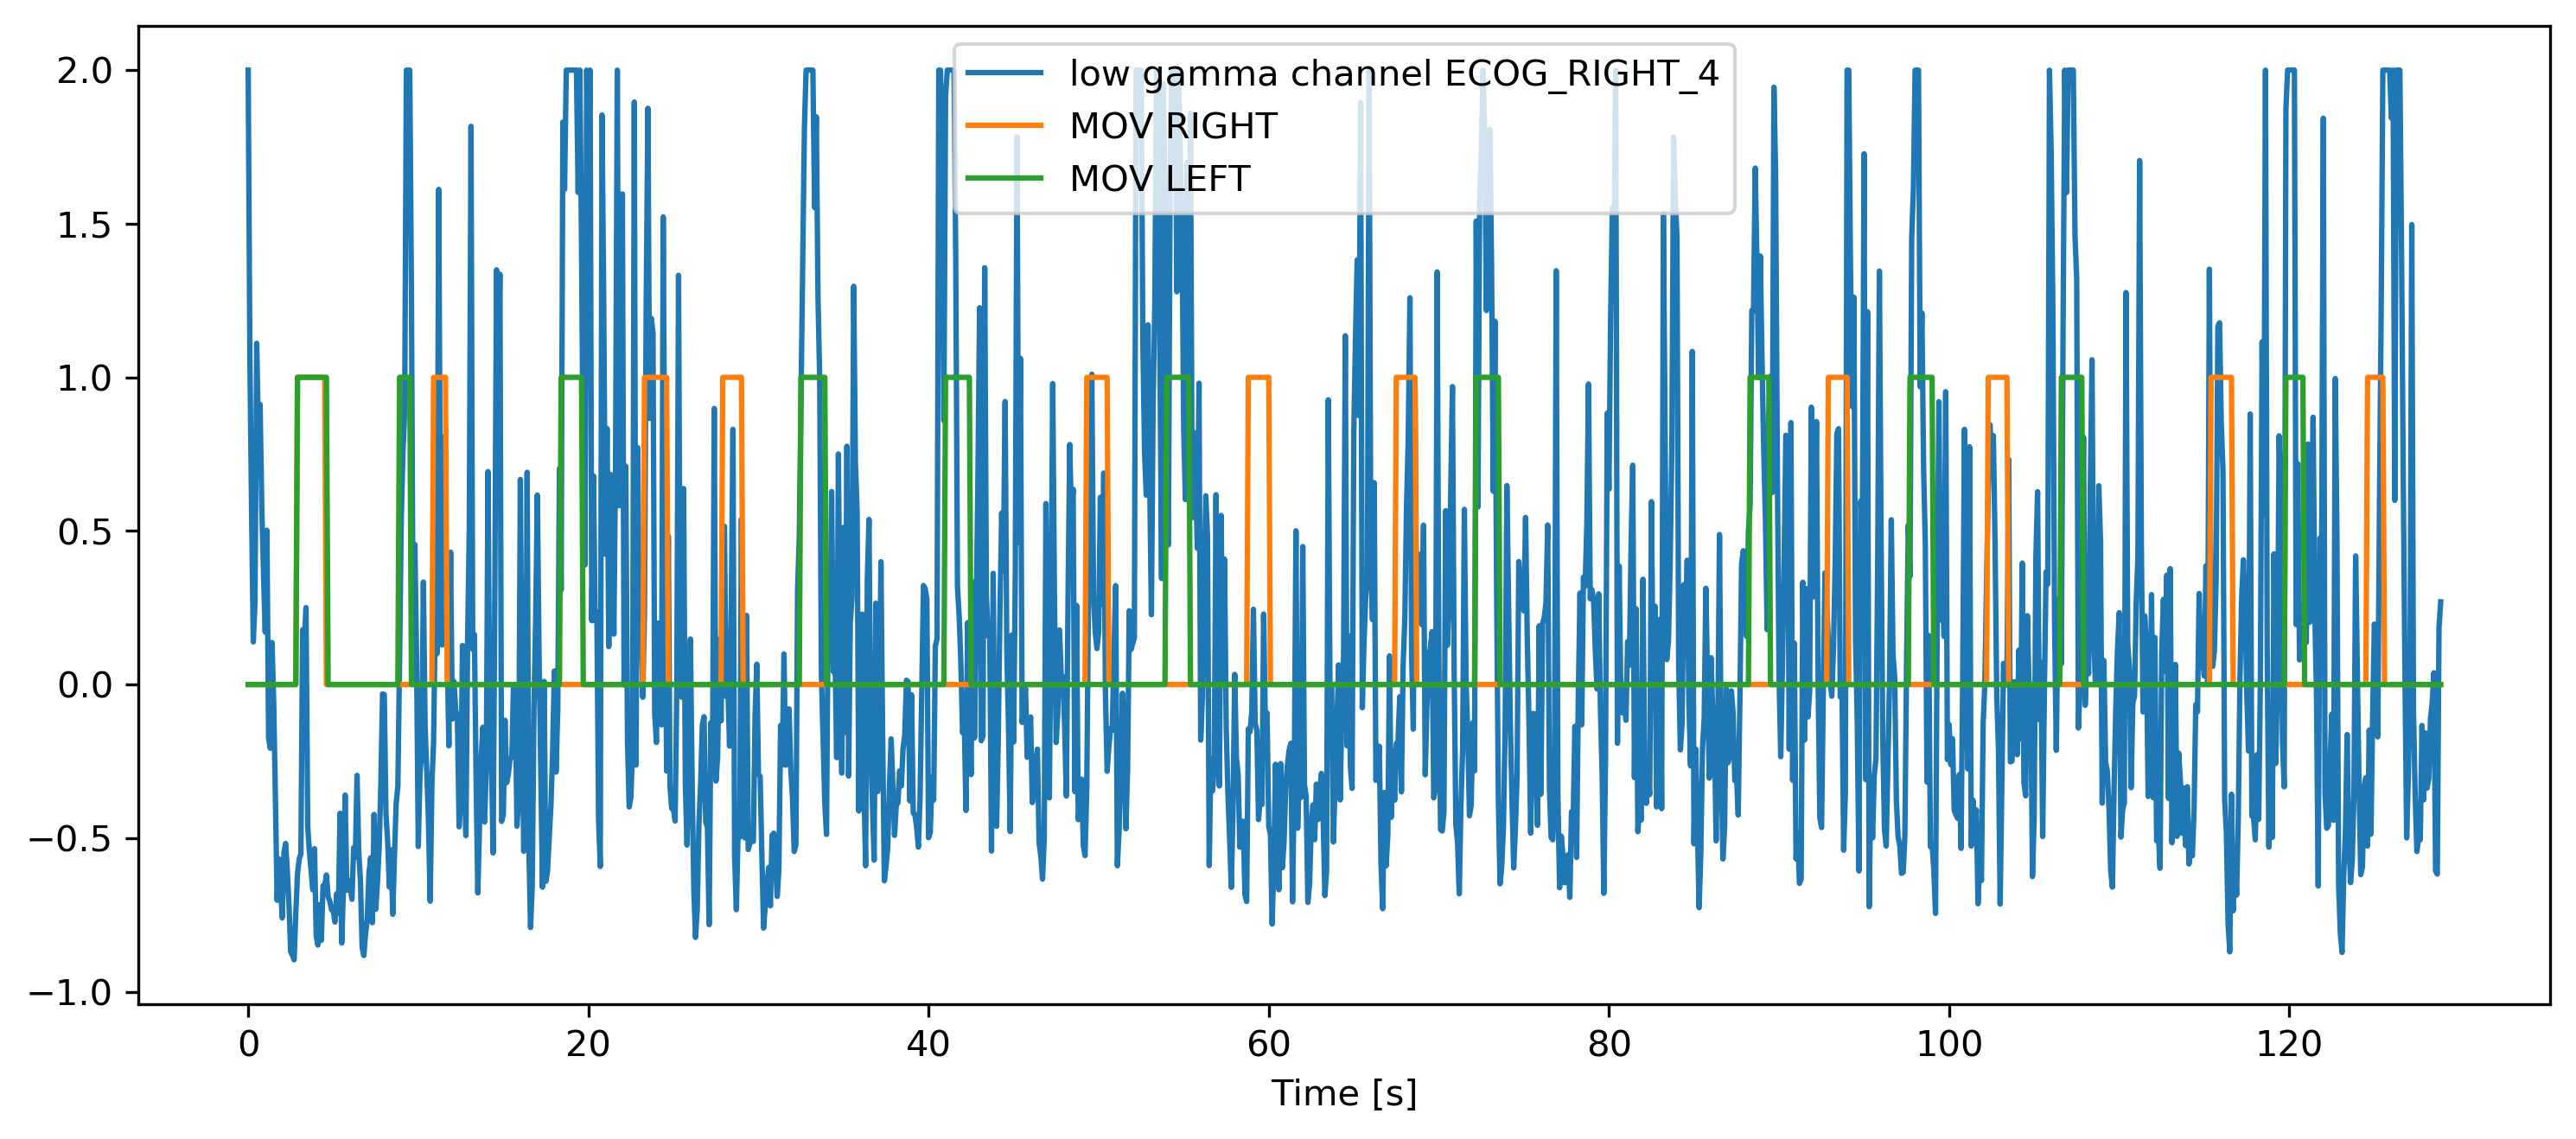

In [37]:
plt.figure(figsize=(12,5), dpi=300)
x_ = np.arange(0, dat["rf_data_median"].shape[0], 1)*0.1
plt.plot(x_, dat["rf_data_median"][:,4,5], label="low gamma channel ECOG_RIGHT_4")
plt.plot(x_, dat["label"][0,:], label="MOV RIGHT")
plt.plot(x_, dat["label"][1,:], label="MOV LEFT")
plt.xlabel("Time [s]")
plt.legend()

Preliminaries: 
 - prediction matrix F: how we get the next state  (state transition matrix)
     is here [1 Tp; 0 1] where Tp is the prediction interval (here 10 Hz) 
 - state would be here: state x AND it's derivative (2D)
     [dk dk']
 - measurement function H: how are states and measurements combined? 
     is here [1 0] since z_k = [1 0] s_k  + v_k
 - and w_k is process distrurbance, 0 mean and Q as cov matrix

In [ ]:
# tuning params: sigma_w and sigma_v

In [43]:
ieeg_sig = dat["rf_data_median"][:,4,5] # low gamma channel ECOG_RIGHT_4

In [47]:
state_space = np.array([ieeg_sig[1:], np.diff(ieeg_sig)])

In [48]:
state_space.shape

(2, 1289)

so it will be a loop of 
1. z, R = read the sensor data z, with noise R (here sigma_v)
2. x, P = predict(x, P, F, Q) # P, F, Q are fixed, but P will be updated (cov matrix
    of the state estimate)
3. x, P = update(x, P, z, R, H) # then given the prediction AND the obtained state z
    a new (better and "true") measurement x will be obtained, use this x

In [87]:
# init
Tp = 0.1
sigma_w = 0.7
sigma_v = 1 # == R in this context


f = KalmanFilter (dim_x=2, dim_z=1)
f.x = np.array(state_space[:,0])
f.F = np.array([[1, Tp], [0, 1]])
f.H = np.array([[1, 0]])
f.R = sigma_v
f.Q = np.array([[(sigma_w**2)*(Tp**3)/3, (sigma_w**2)*(Tp**2)/2],\
                [(sigma_w**2)*(Tp**2)/2, (sigma_w**2)*Tp]])
f.P = np.cov(state_space) #first covariance matrix of the state, check init params

In [88]:
# loop
res_filtered = np.zeros(ieeg_sig.shape[0])
for i in range(ieeg_sig.shape[0]):
    z = ieeg_sig[i]
    f.predict() # predict(x, P, F, Q)
    f.update(z) # x, P = update(x, P, z, R, H)
    res_filtered[i] = f.x[0]

(0, 60)

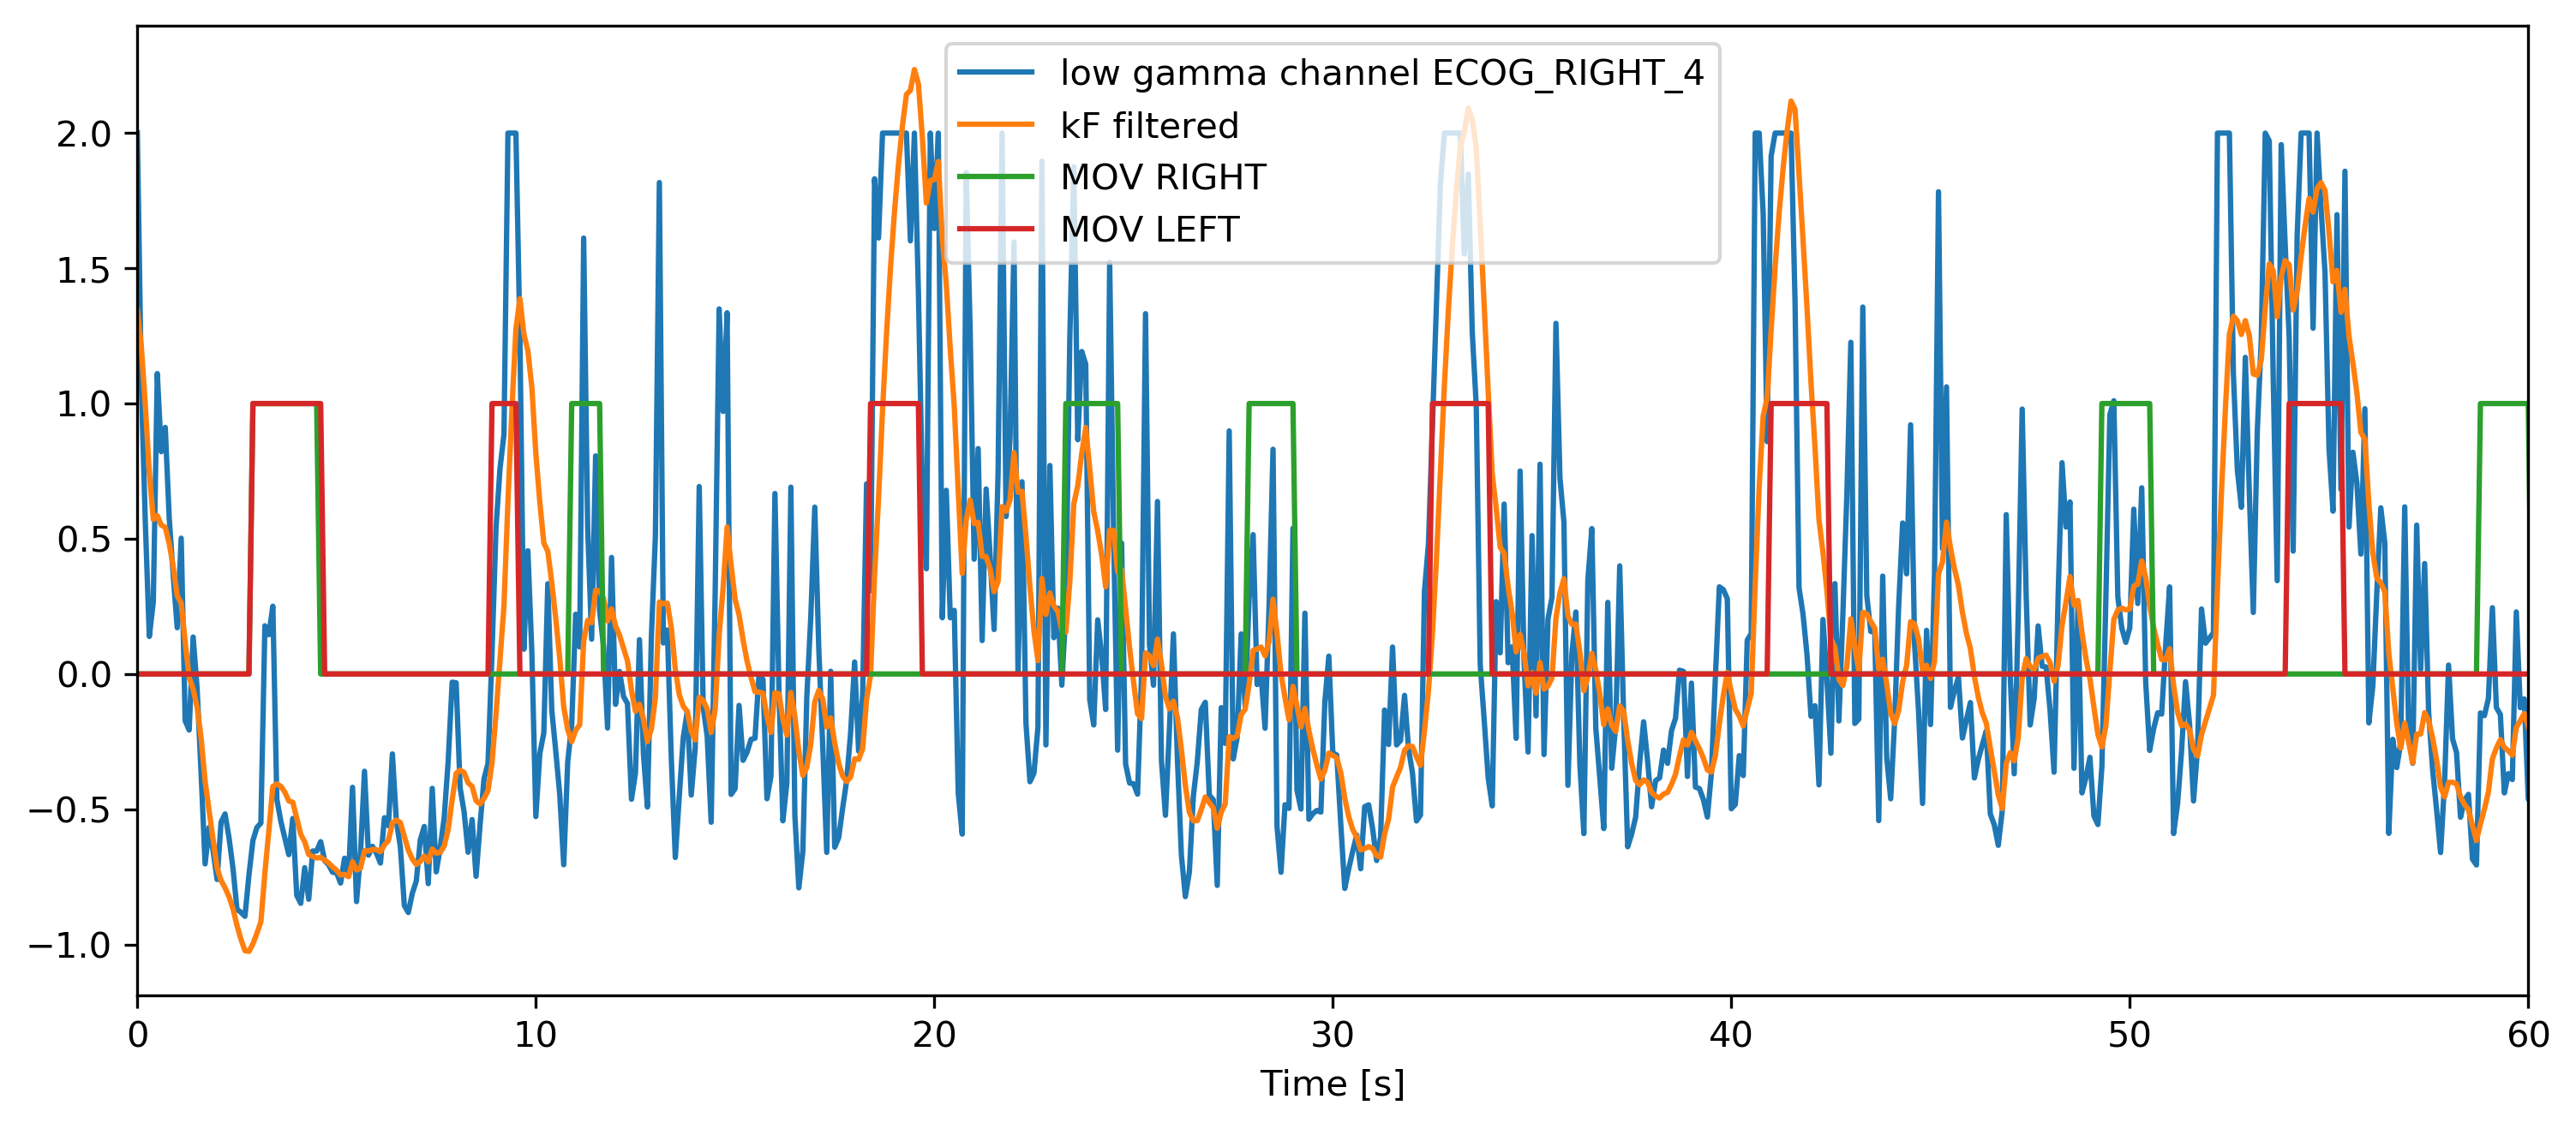

In [89]:
plt.figure(figsize=(12,5), dpi=300)
x_ = np.arange(0, dat["rf_data_median"].shape[0], 1)*0.1
plt.plot(x_, dat["rf_data_median"][:,4,5], label="low gamma channel ECOG_RIGHT_4")
plt.plot(x_, res_filtered, label="kF filtered")
plt.plot(x_, dat["label"][0,:], label="MOV RIGHT")
plt.plot(x_, dat["label"][1,:], label="MOV LEFT")
plt.xlabel("Time [s]")
plt.legend()
plt.xlim(0, 60)